# The quintic Ornstein-Uhlenbeck model VIX futures

In [1]:
import pandas as pd
import BlackScholes as bs
import variance_curve as vc
import risk_free_rates as rf
import implied_q as iq
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.optimize import least_squares as ls
from scipy.integrate import quad

In [2]:
def horner_vector(poly, n, x):
    #Initialize result
    result = poly[0].reshape(-1,1)
    for i in range(1,n):
        result = result*x + poly[i].reshape(-1,1)
    return result

In [3]:
def gauss_dens(mu,sigma,x):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def vix_futures(H, eps, T, a_k_part, k, r, q, n_steps):

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part
    a_k = np.array([a0, a1, a2, a3, a4, a5])
    
    kappa_tild = (0.5-H)/eps
    eta_tild = eps**(H-0.5)

    delt = 30/365
    T_delta = T + delt

    std_X = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    dt = delt/(n_steps)
    tt = np.linspace(T, T_delta, n_steps+1)
    
    FV_curve_all_vix = vc.variance_curve(tt)
    
    exp_det = np.exp(-kappa_tild*(tt-T))
    cauchy_product = np.convolve(a_k,a_k)
    
    std_Gs_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*(tt-T))))
    std_X_t = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    std_X_T = std_X
    
    n = len(a_k)
    
    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
    scipy.special.factorial2(np.arange(0,2*n,2).reshape(-1,1)-1),axis=0) #g(u)
    
    beta = []
    for i in range(0,2*n-1):
        k_array = np.arange(i,2*n-1)
        beta_temp = ((std_Gs_T**((k_array-i).reshape(-1,1))*((k_array-i-1)%2).reshape(-1,1)*\
            scipy.special.factorial2(k_array-i-1).reshape(-1,1)*\
            (scipy.special.comb(k_array,i)).reshape(-1,1))*\
            exp_det**(i))*cauchy_product[k_array].reshape(-1,1)
        beta.append(np.sum(beta_temp,axis=0))

    beta = np.array(beta)*FV_curve_all_vix/normal_var
    beta = (np.sum((beta[:,:-1]+beta[:,1:])/2,axis=1))*dt
    
    sigma = np.sqrt(eps**(2*H)/(1-2*H)*(1-np.exp((2*H-1)*T/eps)))
    
    f = lambda x: np.sqrt(horner_vector(beta[::-1], len(beta), x)/delt)*100 * gauss_dens(0, sigma, x)

    Ft, err = quad(f, -np.inf, np.inf)
    
    return Ft * np.exp((r-q)*T)

In [5]:
data = pd.read_csv("vix_opt.csv")
vix_T = np.array(data["Exp Date"])[2:]
vix_f = np.array(data["Futures"])[2:]
IV = np.array(data.iloc[:,2:])[2:,:]/100
k = np.array([80, 90, 95, 97.5, 100, 102.5, 105, 110, 120])/100
S0 = 19.81

In [6]:
N = len(vix_T); drift = np.zeros(N);
R = np.zeros(N); Q = np.zeros(N);

for i in range(N):
    T = vix_T[i]; F = vix_f[i];
    drift[i] = -np.log(S0/F)/T
    R[i] = rf.r(T)
    Q[i] = R[i] - drift[i]

In [7]:
nr = len(vix_T); nc = len(k); n = 2000;
model_f = np.zeros(nr); model_param_f = np.zeros([nr, 6]);
inp = np.array([ 0.2, 0.01, 1, 0.01, 0.02, 0.05]) #H,eps,a0,a1,a3,a5
bnds = ([-0.1, 1e-10, 0, 0, 0, 0],[0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
start_all = time.time()

for i in range(nr):
    
    start_time = time.time()
    
    T = vix_T[i]; vol = IV[i,:];
    
    r = R[i]; q = Q[i];
    
    def h(x):
        H,eps,a0,a1,a3,a5 = x
        a_k = np.array([a0, a1, a3, a5])
        return vix_futures(H, eps, T, a_k, k, r, q, n)
    
    def f(x):
        return h(x) - vix_f[i]
    
    res = ls(f, inp, bounds = bnds, max_nfev = 50, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
    model_param_f[i,:] = res.x
    model_f[i] = h(res.x)
    
    print(f'Iteration: {i}\t Elapsed time: {time.time()-start_time: .0f} s')
    
print(f'\nTotal elapsed time: {time.time()-start_all: .0f} s')

print(f'\nMean percentage error: {np.mean(np.abs(model_f-vix_f)/vix_f)*100: .4f}%')

Iteration: 0	 Elapsed time:  3 s
Iteration: 1	 Elapsed time:  3 s
Iteration: 2	 Elapsed time:  3 s
Iteration: 3	 Elapsed time:  3 s
Iteration: 4	 Elapsed time:  3 s
Iteration: 5	 Elapsed time:  1 s
Iteration: 6	 Elapsed time:  2 s
Iteration: 7	 Elapsed time:  1 s
Iteration: 8	 Elapsed time:  3 s
Iteration: 9	 Elapsed time:  3 s
Iteration: 10	 Elapsed time:  4 s
Iteration: 11	 Elapsed time:  4 s
Iteration: 12	 Elapsed time:  4 s
Iteration: 13	 Elapsed time:  4 s
Iteration: 14	 Elapsed time:  4 s
Iteration: 15	 Elapsed time:  4 s
Iteration: 16	 Elapsed time:  4 s
Iteration: 17	 Elapsed time:  4 s
Iteration: 18	 Elapsed time:  6 s

Total elapsed time:  63 s

Mean percentage error:  0.0000%


Text(0.5, 1.0, 'VIX futures local calibration')

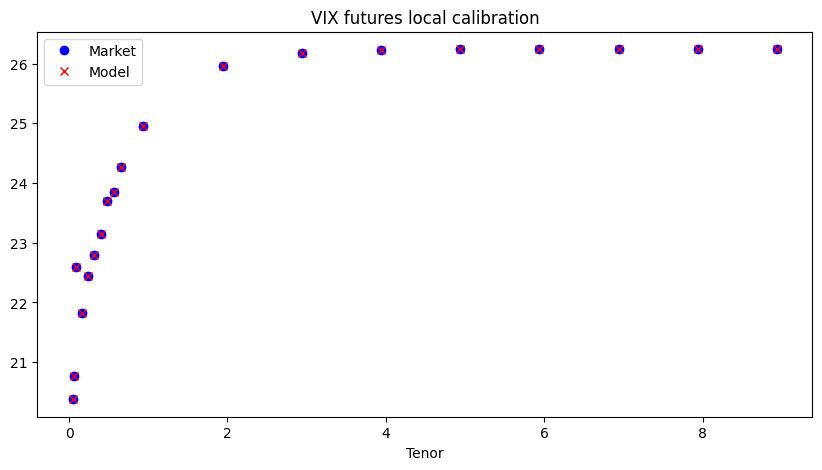

In [10]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(vix_T, vix_f, 'bo')
plt.plot(vix_T, model_f, 'rx')
plt.xlabel("Tenor")
plt.legend(["Market","Model"])
plt.title("VIX futures local calibration")

In [12]:
df = pd.DataFrame(model_param_f, columns = ["H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("Futures_param.csv", index = False)

In [11]:
nr = len(vix_T); nc = len(k); n = 2000;
inp = np.array([ 0.2, 0.01, 1, 0.01, 0.02, 0.05]) #H,eps,a0,a1,a3,a5
bnds = ([-0.1, 1e-10, 0, 0, 0, 0],[0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
start_all = time.time()

def h(x):
    H,eps,a0,a1,a3,a5 = x
    a_k = np.array([a0, a1, a3, a5])
    ft = np.zeros(nr)
        
    for i in range(nr):
        T = vix_T[i]; r = R[i]; q = Q[i];
        ft[i] = vix_futures(H, eps, T, a_k, k, r, q, n)
        
    return ft
    
def f(x):
    return h(x) - vix_f
    
res = ls(f, inp, bounds = bnds, max_nfev = 50, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
model_param_global = res.x
model_global = h(res.x)
    
print(f'\nTotal elapsed time: {time.time()-start_all: .0f} s')

print(f'\nMean percentage error: {np.mean(np.abs(model_global-vix_f)/vix_f)*100: .4f}%')


Total elapsed time:  72 s

Mean percentage error:  0.6920%


Text(0.5, 1.0, 'VIX futures global calibration')

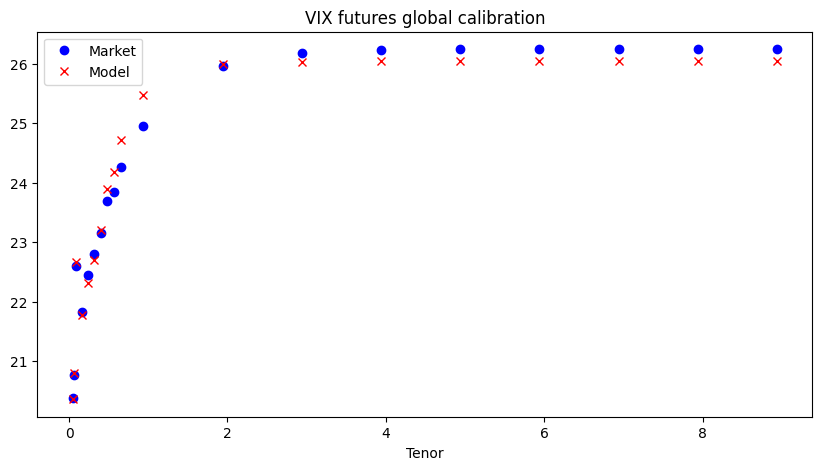

In [12]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(vix_T, vix_f, 'bo')
plt.plot(vix_T, model_global, 'rx')
plt.xlabel("Tenor")
plt.legend(["Market","Model"])
plt.title("VIX futures global calibration")

In [16]:
df = pd.DataFrame(model_param_f, columns = ["H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("Global_futures_param.csv", index = False)